# Lab 2: Exploring Image Data
## by Michael Doherty, Leilani Guzman, and Carson Pittman

## 1. Business Understanding
Self-driving cars. Utter these words and most people will think of a futuristic, technologically advanced society. Yet, believe it or not, the concept of fully autonomous vehicles dates all the way back to the 16th century, when Leonardo da Vinci created a cart that was capable of moving on its own. While it took several centuries before any more progress on autonomous cars was made, since the early 1900s, several advancements have been made in the field. The most notable recent example is Tesla, who has a "Full Self-Driving package" that allows for "hands-free control for highway and freeway driving." Despite this, fully autonomous commercial vehicles have yet to be developed. ([Source](https://www.tomorrowsworldtoday.com/2021/08/09/history-of-autonomous-cars/))

One of the major issues that self-driving cars face is the concept of computer vision. Computer vision is the process by which computers use visual input (such as pictures and videos) to determine what action they should take. For a car to be fully autonomous, it needs to be able to recognize and react to a multitude of scenarios that could occur while driving (in a similiar fashion to how a human driver would react). Thus, self-driving cars need to be able to identify other vehicles and differentiate them from other entities, such as the road and sky.

The dataset we've selected, titled "Vehicle Detection Image Set", was created with this goal in mind. The dataset contains two directories, "vehicles" and "non-vehicles", which can be used to train machine learning models to differentiate between what images contain vehicles and which do not. Each image in the dataset is 64x64 pixels, with pictures in the "vehicles" folder containing images of various cars and pictures in the "non-vehicles" folder containing images of trees, the sky, the road, road signs, and other things a car would "see" while driving.

Thus, the prediction task for this dataset is to determine if any given image contains a vehicle. This is an extremely important concept for a self-driving car to be able to do, so any vehicle company that is working on self-driving cars (both partially and fully autonomous), such as Tesla, would be interested in the results of training machine learning models on this dataset. Hence, the importance of this dataset is clear: it can be used to research new methods for computer vision and improve existing models, all in the hopes of eventually creating a fully self-driving car.

So what does a good prediction algorithm for this dataset look like? There are several factors that need to be considered:
- **Accuracy**: How accurate the prediction algorithm is at classifying vehicles and non-vehicles is one of the most important aspects. As car crashes can be fatal, the prediction algorithm needs to have close to 100% accuracy; at the very least, it needs to be better than humans at identifying what is a vehicle and what is not. 
- **False Positives vs. False Negatives**: The number of false positives (identifying a vehicle when none is present) and false negatives (not identifying a vehicle when one is present) need to be minimized, as both could lead to undesirable situations while driving. However, minimizing the number of false negatives should take priority; while identifying a vehicle when none are present could lead to dangerous situations, failing to identify when a vehicle is present would almost always lead to (potentially fatal) car crashes.
- **Prediction Time**: How long it takes the model to make a prediction for a given image is also extremely important. While driving, an autonomous car is receiving live image data of what is in front of it. If the algorithm takes 5 seconds to make a prediction, it wouldn't be very useful (as it wouldn't be able to make decisions in a safe and reasonable amount of time). Since the average reaction time for humans while driving is 0.75 seconds ([Source](https://www.jdpower.com/cars/shopping-guides/when-driving-what-is-the-average-reaction-time#:~:text=The%20average%20reaction%20time%20when,response%20to%20a%20road%20situation.)), the prediction model should at a minimum be able to match this threshold (and ideally, it should be faster than this).

Ultimately, any machine learning model trained on this data needs to be better than humans to justify its inclusion in an autonomous vehicle. A model that is more accurate, less error prone, and faster at detecting vehicles in an image is a must for any fully autonomous, self-driving car.

Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 2. Data Preparation
### 2.1 Read In and Recolor Images, 2.2 Linearize Images

In [10]:
import numpy as np
import PIL
import PIL.Image
import glob
import matplotlib.pyplot as plt

# load in images and labels as numpy arrays
images_and_labels = []

for filename in glob.glob('data/vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'vehicle')))


for filename in glob.glob('data/non-vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'non_vehicle')))
 

print(images_and_labels[0][0].shape[0]) # linearized 64x64 image -> 4096
print('There are', len(images_and_labels), 'images/rows')

4096
There are 17760 images/rows


### 2.3 Visualize Images

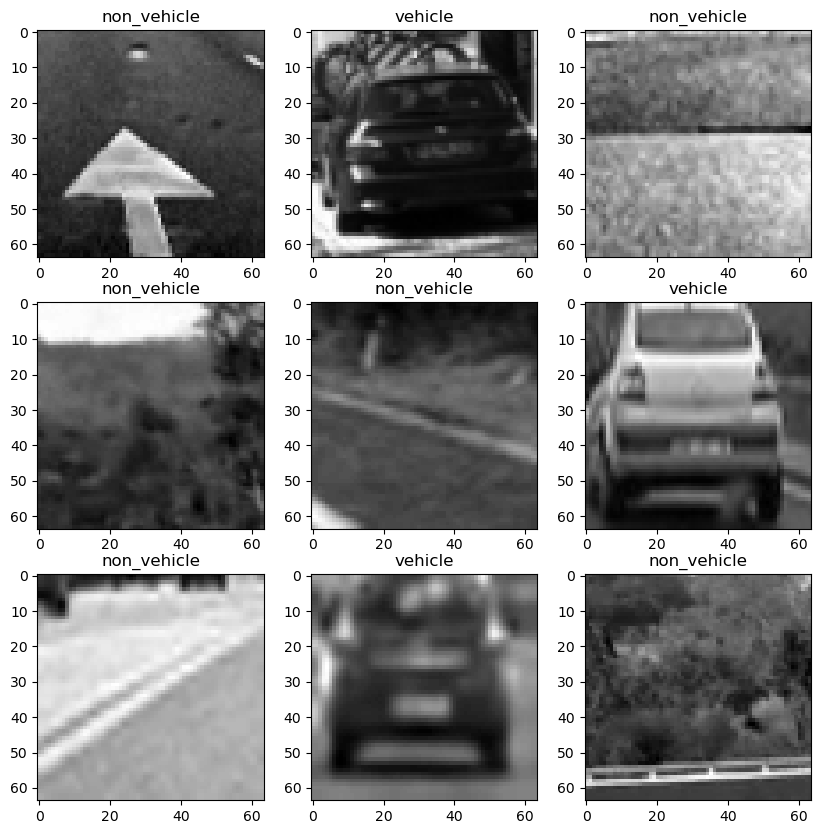

In [11]:
plt.figure(figsize = (10, 10))

# plot some images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(0, len(images_and_labels))
    plt.imshow(images_and_labels[index][0].reshape(64, 64), cmap='gray') # remove cmap if needed
    plt.title(images_and_labels[index][1])

## 3. Data Reduction
### 3.1 Principal Component Analysis

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=images_and_labels[0][0].size, svd_solver='full')
%time pca.fit(np.array([image for image, label in images_and_labels]))
pca.transform(np.array([image for image, label in images_and_labels]))

print ('pca:\n', pca.components_)
print("Explained Variance for Each Component:", pca.explained_variance_ratio_)

CPU times: total: 3min 10s
Wall time: 56.4 s
pca:
 [[ 0.01341869  0.01345809  0.01345946 ...  0.01126829  0.01111007
   0.01107859]
 [-0.01862572 -0.0188311  -0.01910649 ...  0.01515648  0.01449854
   0.01402976]
 [ 0.00960369  0.00955185  0.00954491 ...  0.02386171  0.02344508
   0.02307165]
 ...
 [-0.00018479 -0.00078541  0.00193381 ... -0.00719397  0.00272874
   0.00148049]
 [ 0.00285966 -0.00351638  0.00345942 ... -0.00329091  0.00568907
  -0.00056899]
 [ 0.00252492 -0.00380645  0.00263135 ... -0.00379258  0.00088924
   0.00197363]]
Explained Variance for Each Component: [3.49597359e-01 1.23467294e-01 8.59596569e-02 ... 3.29883110e-08
 3.19984675e-08 3.10395652e-08]


Need 228 Principal Components for an Explained Variance of 95%


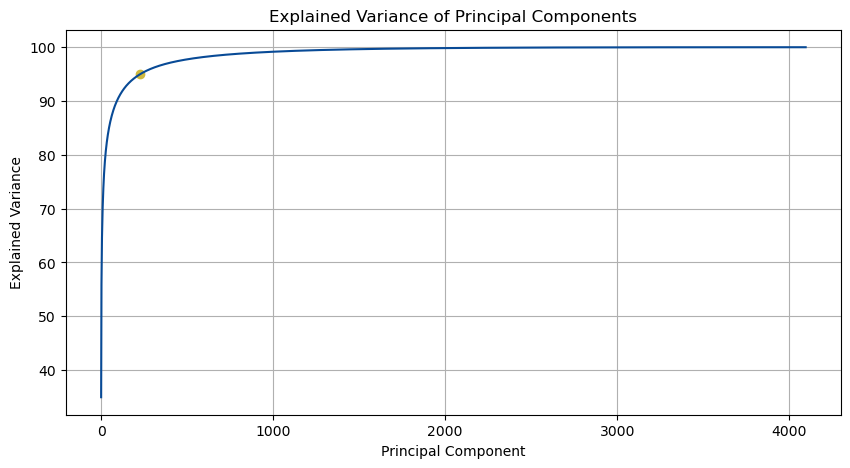

In [70]:
import matplotlib.pyplot as plt

def plot_explained_variance(pca=None, rpca=None, target_variance=None):
    plt.figure(figsize=(10, 5))
    
    if pca is not None:
        pca_explained_variance = pca.explained_variance_ratio_
        pca_cumulative_explained_variance = pca_explained_variance.cumsum()

        if target_variance is not None:
            pc_index = np.where(pca_cumulative_explained_variance >= target_variance)[0][0]
            print('Need {} Principal Components for an Explained Variance of {}%'.format(pc_index, int(target_variance * 100)))
            plt.scatter(pc_index, pca_cumulative_explained_variance[pc_index] * 100, c='#cfb93d')
            
        plt.plot(range(len(pca_explained_variance)), 
                 pca_cumulative_explained_variance * 100, 
                 color='#084a96')

    if rpca is not None:
        rpca_explained_variance = rpca.explained_variance_ratio_
        rpca_cumulative_explained_variance = rpca_explained_variance.cumsum()

        if target_variance is not None:
            pc_index = np.where(rpca_cumulative_explained_variance >= target_variance)[0][0]
            print('Need {} Principal Components for an Explained Variance of {}%'.format(pc_index, int(target_variance * 100)))
            plt.scatter(pc_index, rpca_cumulative_explained_variance[pc_index] * 100, c='black')
            
        plt.plot(range(len(rpca_explained_variance)), 
                 rpca_cumulative_explained_variance * 100, 
                 color='#964B00')

    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance of Principal Components')
    plt.grid()
    plt.show()

plot_explained_variance(pca=pca, target_variance=0.95)

**ADD ANALYSIS AND CONCLUSION** (We chose 95% as a good threshold as it is around the "knee" of the above graph)

### 3.2 Randomized Principal Component Analysis

In [67]:
rpca = PCA(n_components=images_and_labels[0][0].size, svd_solver='randomized')
%time rpca.fit(np.array([image for image, label in images_and_labels]))
rpca.transform(np.array([image for image, label in images_and_labels]))

print ('Randomized pca:\n', rpca.components_)
print("Explained Variance for Each Component:", rpca.explained_variance_ratio_)

CPU times: total: 7min 20s
Wall time: 2min 28s
Randomized pca:
 [[ 0.01341869  0.01345809  0.01345946 ...  0.01126829  0.01111007
   0.01107859]
 [-0.01862572 -0.0188311  -0.01910649 ...  0.01515648  0.01449854
   0.01402976]
 [ 0.00960369  0.00955185  0.00954491 ...  0.02386171  0.02344508
   0.02307165]
 ...
 [-0.00018479 -0.00078541  0.00193381 ... -0.00719397  0.00272874
   0.00148049]
 [ 0.00285966 -0.00351638  0.00345942 ... -0.00329091  0.00568907
  -0.00056899]
 [ 0.00252492 -0.00380645  0.00263135 ... -0.00379258  0.00088924
   0.00197363]]
Explained Variance for Each Component: [3.49597359e-01 1.23467294e-01 8.59596569e-02 ... 3.29883110e-08
 3.19984675e-08 3.10395652e-08]


Need 228 Principal Components for an Explained Variance of 95%


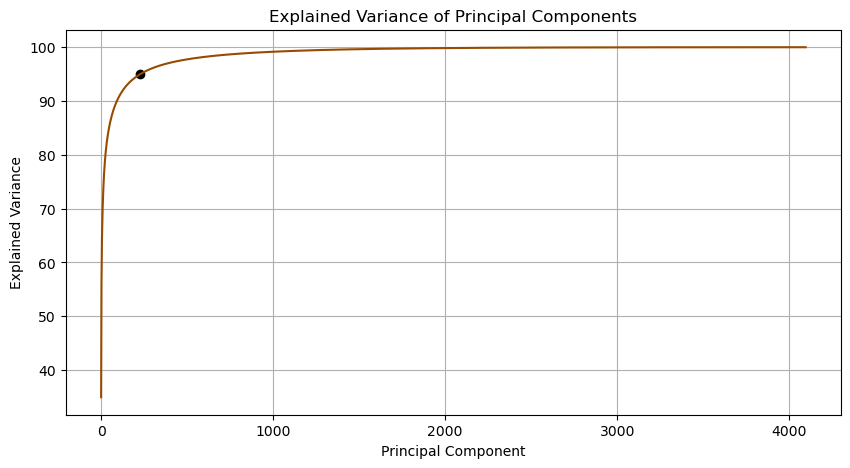

In [71]:
plot_explained_variance(rpca=rpca, target_variance=0.95)

### 3.3 PCA vs. Randomized PCA

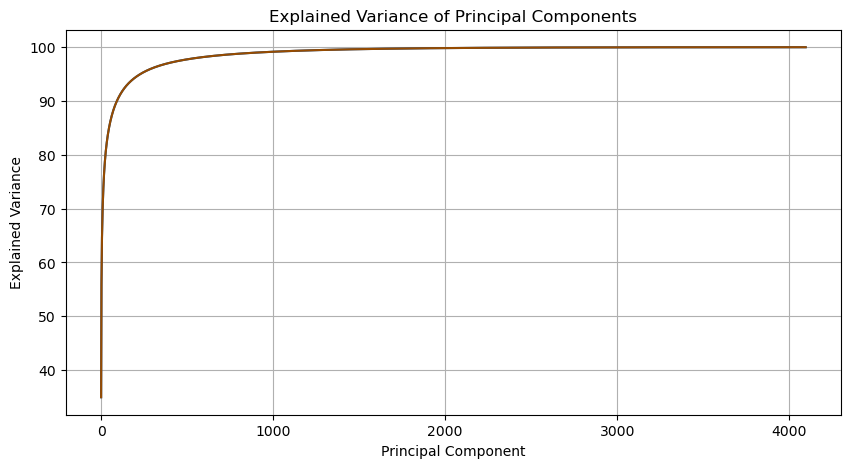

In [72]:
plot_explained_variance(pca=pca, rpca=rpca)

...Explanation (As seen above, both graphs are on top of each other, RPCA is much slower on all dimensions...)

In [73]:
pca = PCA(n_components=228, svd_solver='full')
%time pca.fit(np.array([image for image, label in images_and_labels]))
pca.transform(np.array([image for image, label in images_and_labels]))

CPU times: total: 3min 22s
Wall time: 58.2 s


array([[ 8.01881917e+02,  7.66774326e+02,  2.34759930e+03, ...,
         9.39058356e+00,  2.90108030e+01,  7.79529594e+01],
       [-1.68853501e+03,  4.00034653e+02,  8.49999810e+02, ...,
        -3.55911587e+01,  3.74943375e+01, -1.26340723e+01],
       [-4.93180745e+02,  5.50903620e+02,  7.40743989e+02, ...,
        -4.44220289e+01, -7.58492253e+00, -8.73980588e+00],
       ...,
       [ 5.15086514e+02,  1.92395242e+03,  1.09824152e+03, ...,
        -2.73278238e+01, -1.73897544e+01,  1.53786457e+01],
       [ 1.05081013e+03,  2.28876727e+03,  8.58653348e+02, ...,
         1.94775603e+01, -6.43596195e+01, -8.68420370e+01],
       [ 1.95900491e+03,  2.39148244e+03, -1.50561654e+02, ...,
         1.01376547e+01,  2.97385229e-01, -2.86228494e-01]])

In [74]:
rpca = PCA(n_components=228, svd_solver='randomized')
%time rpca.fit(np.array([image for image, label in images_and_labels]))
rpca.transform(np.array([image for image, label in images_and_labels]))

CPU times: total: 23.6 s
Wall time: 6.63 s


array([[  801.88191697,   766.77432574,  2347.5992995 , ...,
          122.04420333,    -5.12507803,    -7.45436948],
       [-1688.53500566,   400.03465257,   849.9998099 , ...,
           39.68189843,    12.38842364,    43.34431929],
       [ -493.18074461,   550.90361951,   740.7439893 , ...,
           42.63842501,    34.60599497,   -24.38973182],
       ...,
       [  515.08651358,  1923.95241617,  1098.24152048, ...,
           13.0928338 ,     5.1264979 ,   -73.07106017],
       [ 1050.8101255 ,  2288.76726503,   858.65334762, ...,
          -65.58363611,   -11.07594944,    50.01241768],
       [ 1959.00490748,  2391.48243957,  -150.56165417, ...,
          -18.63034741,    54.47067229,    14.5997791 ]])

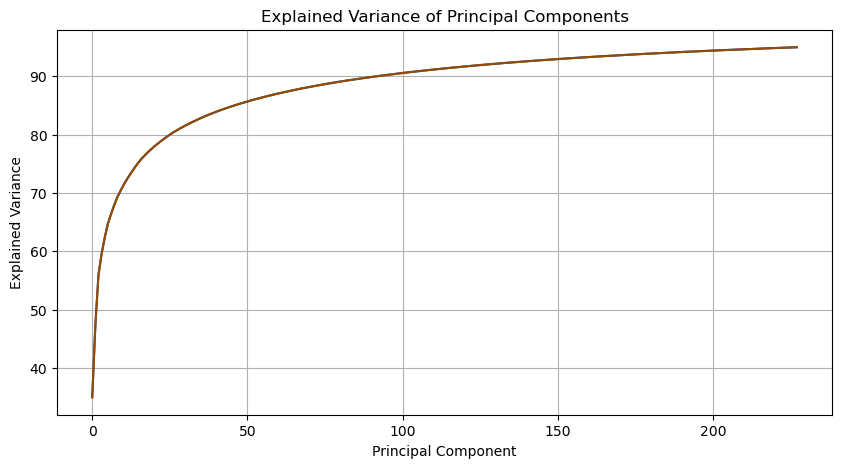

In [75]:
plot_explained_variance(pca=pca, rpca=rpca)

Explanation... (same values, Randomized PCA is much faster)

### 3.4 Feature Extraction using DAISY

In [24]:
from skimage.feature import daisy
from sklearn.metrics.pairwise import pairwise_distances
import copy

def use_daisy(img, dim):
    features = daisy(img.reshape((dim,dim)), step=10, radius=15, rings=2, histograms=8, orientations=4)
    return features.reshape((-1))

# For every image, use daisy to extract features
daisy_features = np.apply_along_axis(use_daisy, 1, np.array([image for image, label in images_and_labels]), 64)
print('Daisy Features Shape:', daisy_features.shape)

distance_matrix = pairwise_distances(daisy_features)


Daisy Features Shape: (17760, 1088)


(-0.5, 63.5, 63.5, -0.5)

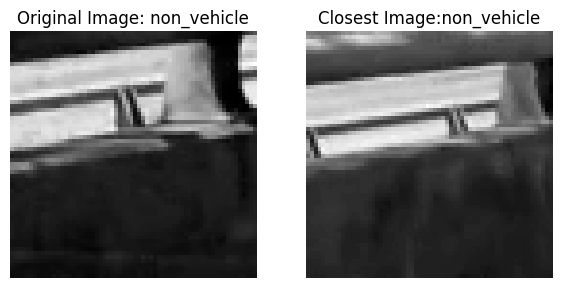

In [25]:
# Find closest image to current image
import sys

index1 = np.random.randint(0, len(images_and_labels))
distances = copy.deepcopy(distance_matrix[index1,:])
distances[index1] = sys.maxsize
index2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
plt.imshow(images_and_labels[index1][0].reshape((64,64)), cmap='gray')
plt.title("Original Image: " + images_and_labels[index1][1])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(images_and_labels[index2][0].reshape((64,64)), cmap='gray')
plt.title("Closest Image:" + images_and_labels[index2][1])
plt.axis('off')

As seen in the above comparison, this method was able to find a match of the same class that also has very similar features to the original (based on human intuition). Based on this example alone it seems the DAISY feature extraction method is a valid prediction method for this dataset; however, further testing and analysis is needed to confirm this, which will be done in the next section.

### 3.5 DAISY Feature Extraction Analysis

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Recreate PCA features with principal component as determined above
pca = PCA(n_components=pc_index)
pca_features = pca.fit_transform([image for image, label in images_and_labels])
y = [label for image, label in images_and_labels]

knn_PCA = KNeighborsClassifier(n_neighbors=1)
knn_DAISY = KNeighborsClassifier(n_neighbors=1)

PCA_train, PCA_test, DAISY_train, DAISY_test, y_train, y_test = train_test_split(pca_features, daisy_features, y, test_size=0.2)

# Fit and predict using PCA features
knn_PCA.fit(PCA_train, y_train)
PCA_accuracy = accuracy_score(knn_PCA.predict(PCA_test), y_test)

# Fit and predict using DAISY features
knn_DAISY.fit(DAISY_train, y_train)
DAISY_accuracy = accuracy_score(knn_DAISY.predict(DAISY_test), y_test)

print('PCA Accuracy: {:.2f}%'.format(PCA_accuracy * 100))
print('DAISY Accuracy: {:.2f}%'.format(DAISY_accuracy * 100))

c:\Users\Carson Pittman\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Carson Pittman\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Carson Pittman\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Carson Pittman\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Carson Pittman\AppData

PCA Accuracy: 93.95%
DAISY Accuracy: 96.99%


In the preceding code segment, we conducted an evaluation of the DAISY method's efficacy in classifying images using KNN Classifier algorithms, and compared it to the PCA method previously used. The daisy_features and the pca_features (calculated using the optimized principal componenets value determined previously) were then divided into testing and training sets, complete with their corresponding labels. At this point separate KNN objects were created, for both PCA and DAISY, to fit the training data and then predict the label of each image. The overall accuracy was then calculated based on how many predictions were correct for both DAISY and PCA. The DAISY method was able to correctly predict the class of the image about 97% of the time, which is a small improvement over the PCA method that correctly predicted the class about 94% of the time. This is a very promising result, as it shows while both methods are valid for making predictions in this dataset, the DAISY method is slightly more accurate and therefore a better choice for this dataset.

## 4. Feature Extraction Using DAISY Key Point Matching

### 4.1 Overview of DAISY Key Point Matching

A common method in image processing is feature extraction, as part of this method there is an algorithm referred to as feature descriptors. Feature descriptors take an image as input and output feature descriptors(vectors), which encode points of interest in an image as a string of numbers often referred to as a "numerical fingerprint". DAISY is a feature descriptor that utilizes gradient oriented histograms which enables it to quickly extract dense features; this is useful in "bag-of-features" image representations. It combines local image features and keypoints to determine corresponding points between images. In "[Fast Rotation-Invariant DAISY Descriptor for Image Keypoint Matching](https://ieeexplore.ieee.org/document/5693839)", the process and general background of DAISY keypoint matching is explained. Below is a brief overview of the process:

The process of determing these corresponding points is usually divided into three main steps:
1. Extract keypoints in the images in their own distinctive way (such as corners).
2. Represent pixels within a certain radius of a keypoint as a vector.
3. Match these descriptor vectors between images according to similarity (distance between vectors). This commonly uses either Euclidean or Mahalanobis distance.

Using this basic process we will be able to break down each image into its own set of daisy descriptors, which will then be used to match keypoints between, and the best match will be saved. This will be done for each pair of images, and the number of matches will be recorded, which will be used as a metric to determine how similar each pair of images are.

DAISY Descriptors (P,Q,R):  (4, 4, 68)


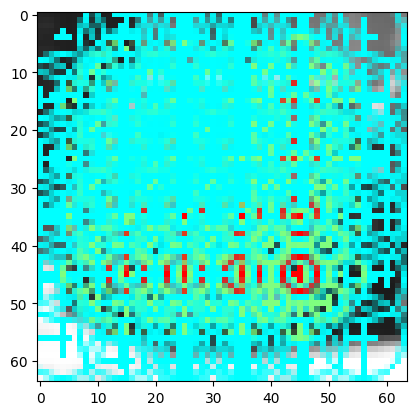

In [27]:

# Take 2000 images from the first half of the dataset and 2000 from the second half
# to ensure there are vehicles and non-vehicles in the sample
images_and_labels_2 = images_and_labels[:2000] + images_and_labels[10000:12000]

# Example on one image
features, image_description = daisy(images_and_labels_2[0][0].reshape((64,64)), step=10, radius=15, rings=2, histograms=8, 
                                    orientations=4, visualize=True)

plt.imshow(image_description)

print('DAISY Descriptors (P,Q,R): ', features.shape)

The above image is what the DAISY descriptors look like, but will not be visualized in the further analysis.

In [28]:

def use_daisy(img, dim):
    features = daisy(img.reshape((dim,dim)), step=10, radius=15, rings=2, histograms=8, orientations=4)
    new_shape = features.shape
    return features.reshape((new_shape[0]*new_shape[1], new_shape[2]))

# Apply daisy to all images
d_images_and_labels = [tuple((use_daisy(image, 64), label)) for image, label in images_and_labels_2]

print('DAISY features shape', d_images_and_labels[0][0].shape)


DAISY features shape (16, 68)


In [29]:
from skimage.feature import match_descriptors

matches_found = []

# Find matches between every pair of images, and keep the best match for each pair
for i in range(len(d_images_and_labels)):
    best_percentage = 0
    best_match_index = 0

    best_num_matches = -sys.maxsize
    for j in range(i + 1, len(d_images_and_labels)):
        if i != j:
            matches = match_descriptors(d_images_and_labels[i][0], d_images_and_labels[j][0], cross_check=True, max_ratio=0.8)
            similarity_percentage = 100*matches.shape[0]/d_images_and_labels[i][0].shape[0]
            if similarity_percentage > best_percentage:
                best_percentage = similarity_percentage
                best_match_index = j
                best_num_matches = matches.shape[0]
    matches_found.append(tuple((best_num_matches, i, best_match_index)))

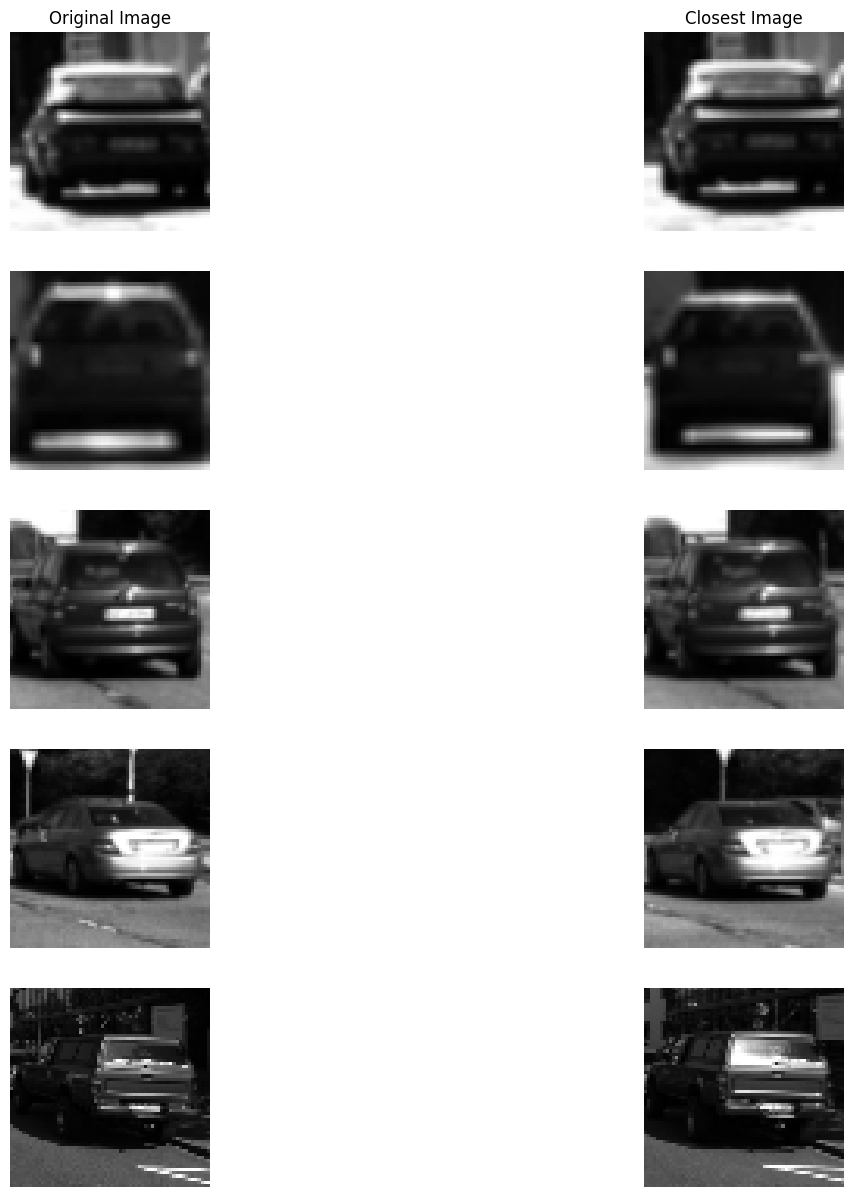

In [30]:
# Plotting 10 matches (of vehicles)
plt.figure(figsize=(15, 15))
for i in range(5):
    # Plotting the original image (left) and the closest match (right)
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(images_and_labels_2[matches_found[i][1]][0].reshape((64,64)), cmap='gray')
    plt.axis('off')
    plt.title('Original Image') if i == 0 else None
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(images_and_labels_2[matches_found[i][2]][0].reshape((64,64)), cmap='gray')
    plt.title('Closest Image') if i == 0 else None
    plt.axis('off')

Following the matching of keypoints between images, the number of matches recorded is used as a metric to determine similarity between pairs of images. To quanitfy this similarity, a percentage is computed by dividing the number of matches by the total number of keypoints in the first image. This percentage serves as a reliable indicator of the degree of similarity between image pairs.

The above plot showcases images extracted from the first half of the dataset, which predominantly features vehicle images. These images are shown with their closest counterparts determined by DAISY keypoint matching. In most cases, as seen in the displayed samples, the closest matching image belongs to the same vehicle class, and it is also usually the same image but taken with a slightly different angle or lighting. This demonstrates that DAISY keypoint matching is an effective way to determine image similarity.

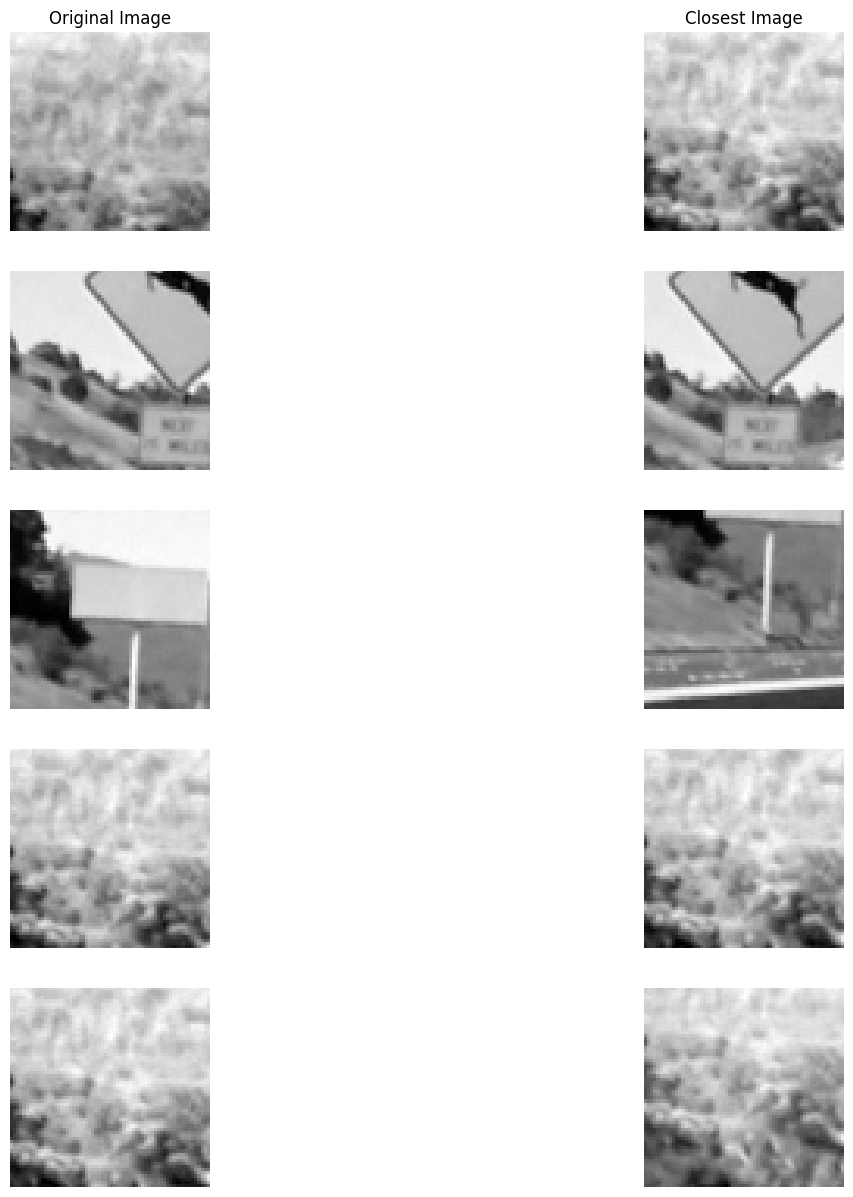

In [31]:
# Plotting 10 matches (of non-vehicles)
plt.figure(figsize=(15, 15))
for i in range(5):
    # Plotting the original image (left) and the closest match (right)
    plt.subplot(5, 2, 2*i + 1)
    # i + 2500 to pick images from latter half of dataset
    plt.imshow(images_and_labels_2[matches_found[i+2100][1]][0].reshape((64,64)), cmap='gray')
    plt.axis('off')
    plt.title('Original Image') if i == 0 else None
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(images_and_labels_2[matches_found[i+2100][2]][0].reshape((64,64)), cmap='gray')
    plt.title('Closest Image') if i == 0 else None
    plt.axis('off')


In this plot the images showcased are extracted from the latter half of the dataset, which predominatly features non-vehicle images. These images are also shown with their closest counterparts determined by DAISY keypoint matching as seen in the previous example.The closest matching image belongs to the same non-vehicle class, and it is also usually the same image but taken with a slightly different angle or lighting, such as the two images of the deer crossing sign that are at slightly diferent angles. This further demonstrates that DAISY keypoint matching is an effective way to determine image similarity.

In [32]:
# Using KNNClassifier with keypoint matches as features
y = [label for image, label in images_and_labels_2]

knn = KNeighborsClassifier(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(matches_found, y, test_size=0.2)

knn.fit(X_train, y_train)
accuracy = accuracy_score(knn.predict(X_test), y_test)

print('DAISY Keypoint Matching Accuracy: {:.2f}%'.format(accuracy * 100))

DAISY Keypoint Matching Accuracy: 99.88%


### 4.2 Discussion of Results

The images previously shown are beneficial in getting a general idea of the effectiveness of this process, but in order to accurately quanitify its effectiveness, a more in-depth analysis is required. To do this a KNN Classifier is used with the matches_found as the features and the class of the image as the target. The KNN Classifier is used with a value of 1 for k, in order to determine the closest neighbor to better predict the class of the image. The accuracy of this classifier is then used as a metric to determine the effectiveness of the DAISY keypoint matching process. The accuracy of this classifier was determined to be around 99%, which is extremely high, and demonstrates that the DAISY keypoint matching process is an effective way to classify images as vehicle or non-vehicle based on the class of its most similar image.